In [1]:
import numpy as np
import random
from PIL import Image
import networkx as nx
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib widget

from cubic_spline_fit import CubicSpline2D, cubic_func
from extract_network import find_color, extract_network, render_skeleton, render_network

/home/ss/anaconda3/envs/extract_raster/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def image_to_graph(img: Image, simplify: bool=True) -> nx.Graph:
    rgb = (255, 255, 255)
    px = find_color(img, rgb).T
    return extract_network(px, min_distance=4, simplify=simplify)

def graph_to_polylines(g: nx.Graph, simplify: bool=True) -> list:
    polylines = []
    for (n1, n2, k) in g.edges(keys=True):
        edge = g[n1][n2][k]
        path = edge['path']
        if simplify:
            coords = np.array(path.coords)
        else:
            coords = np.array(path)
        polylines.append(coords)
    return polylines


img_id = 1
png_file = f'samples/gt/{img_id}_gray.png'
img = Image.open(png_file)

simplify = False
skel, graph = image_to_graph(img, simplify=simplify)
polylines = graph_to_polylines(graph, simplify=simplify)

Skeleton px=1718
Adding 0/0 dense nodes to existing 22 nodes.
Extracted street network:
  - 19 nodes
  - 28 edges


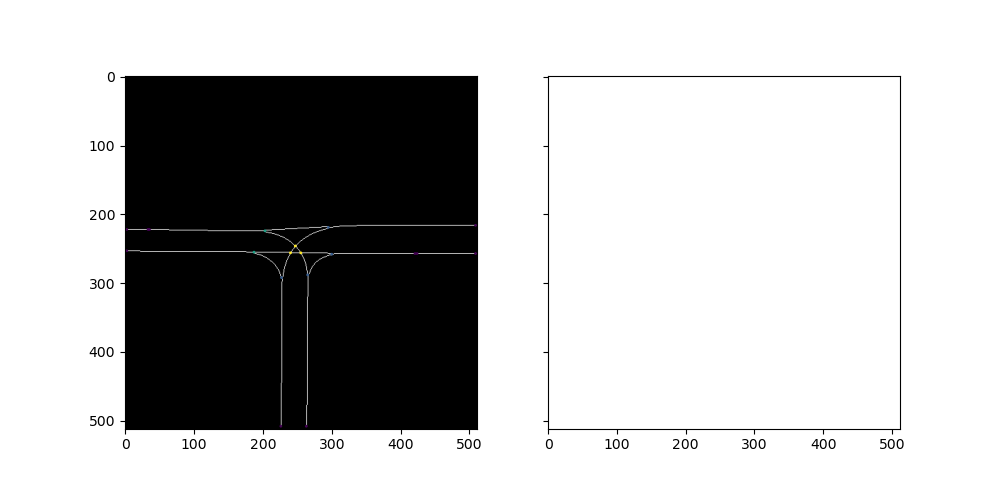

In [3]:
def plot_graph(graph: nx.Graph) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
    axes = axes.ravel()
    
    # nodes = np.array(graph.nodes(), dtype=float)

    # c = np.random.randint(1, 5, size=nodes.shape[0])
    # s = np.random.randint(10, 220, size=N)

    # nodes_deadend = []
    # nodes_transit = []
    # nodes_branch = []
    # nodes_intersect = []
    # for (node, degree) in graph.degree():
    #     if degree == 1:
    #         nodes_deadend.append(node)
    #     elif degree == 2:
    #         nodes_transit.append(node)
    #     elif degree % 2 == 1:
    #         nodes_branch.append(node)
    #     elif degree % 2 == 0:
    #         nodes_intersect.append(node)

    nodes = np.array([node for (node, val) in graph.degree()], dtype=float)
    degrees = np.array([val for (node, val) in graph.degree()], dtype=float)

    # for (node, degree) in graph.degree():
    #     print(f'node {node}')
    #     print(f'degree {degree}')

    axes[0].imshow(skel, cmap='gray')
    # axes[0].scatter(nodes[:, 1], nodes[:, 0], c='r', s=1)
    axes[0].scatter(nodes[:, 1], nodes[:, 0], c=degrees, s=1)

    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')

    plt.show()
    
    return

plot_graph(graph)

/home/ss/anaconda3/envs/extract_raster/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ss/anaconda3/envs/extract_raster/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ss/anaconda3/envs/extract_raster/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ss/anaconda3/envs/extract_raster/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ss/anaconda3/envs/extract_raster/lib/pytho

 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number 

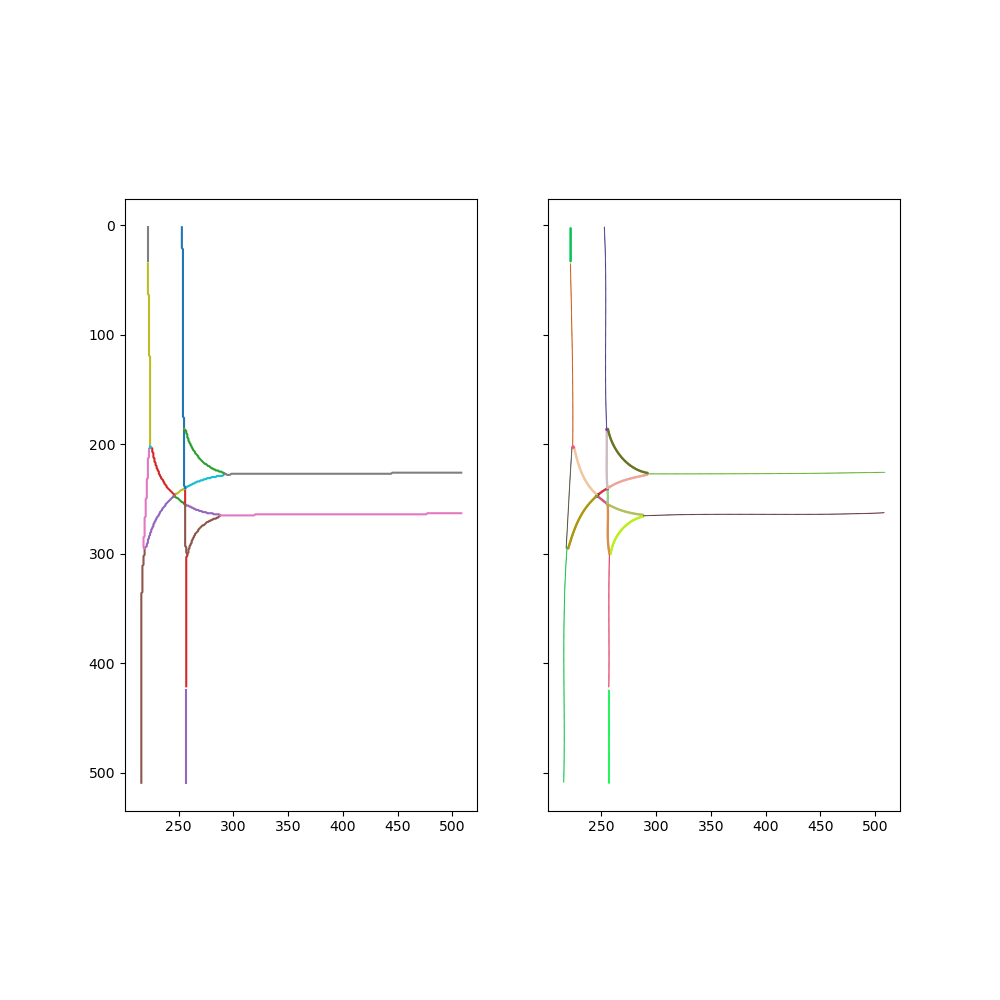

In [4]:
# def generate_frenet_frame(centerline_pts: np.ndarray):
def generate_frenet_frame(xs: np.ndarray, ys: np.ndarray):
    cubic_spline = CubicSpline2D(xs, ys)
    s = np.arange(0, cubic_spline.s[-1], 1)
    # s = np.linspace(0, cubic_spline.s[-1], xs.shape[0])
    ref_xy = [cubic_spline.calc_position(i_s) for i_s in s]
    ref_yaw = [cubic_spline.calc_yaw(i_s) for i_s in s]
    ref_rk = [cubic_spline.calc_curvature(i_s) for i_s in s]
    return cubic_spline, np.column_stack((ref_xy, ref_yaw, ref_rk))

def plot_polylines(polylines: list) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)
    axes = axes.ravel()

    def random_color():
        return '#{:02X}{:02X}{:02X}'.format(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    
    def generate_random_colors(n):
        return [random_color() for _ in range(n)]

    color = generate_random_colors(len(polylines))

    for i, polyline in enumerate(polylines):
        xs = polyline[:, 0]
        ys = polyline[:, 1]
        axes[0].plot(xs, ys)

        cubic_spline, ref_curve = generate_frenet_frame(xs, ys)
        dy = np.sin(ref_curve[:, 2]) / 5
        dx = np.cos(ref_curve[:, 2]) / 5
        axes[1].quiver(ref_curve[:, 0], ref_curve[:, 1], dx, dy, color=color[i], angles='xy', scale_units='xy', scale=0.1)
        
        # popt, pcov = curve_fit(cubic_func, xs, ys, check_finite=True)
        # fit_score = np.linalg.cond(pcov)
        # axes[1].plot(xs, cubic_func(xs, *popt), 'g--')

    # img_skeleton = render_skeleton(img, skel, (255, 0, 0))
    # img_network = render_network(img, g, (0, 255, 0))
    # axes[0].imshow(img_skeleton)
    # axes[1].imshow(img_network)
    axes[0].set_aspect('equal')
    axes[0].invert_yaxis()
    axes[1].set_aspect('equal')
    plt.show()

    return

plot_polylines(polylines)

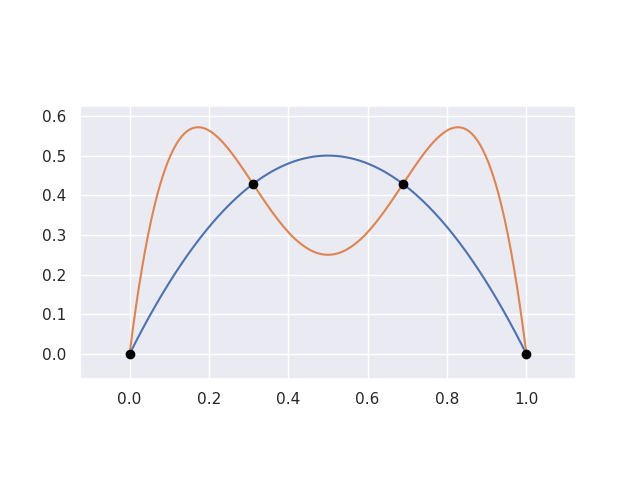

In [5]:
import bezier
import seaborn
import numpy as np

nodes1 = np.asfortranarray([
    [0.0, 0.5, 1.0],
    [0.0, 1.0, 0.0],
])
curve1 = bezier.Curve(nodes1, degree=2)

nodes2 = np.asfortranarray([
    [0.0, 0.25,  0.5, 0.75, 1.0],
    [0.0, 2.0 , -2.0, 2.0 , 0.0],
])
curve2 = bezier.Curve.from_nodes(nodes2)
intersections = curve1.intersect(curve2)

s_vals = np.asfortranarray(intersections[0, :])
points = curve1.evaluate_multi(s_vals)

seaborn.set()
ax = curve1.plot(num_pts=256)
_ = curve2.plot(num_pts=256, ax=ax)
lines = ax.plot(
    points[0, :], points[1, :],
    marker="o", linestyle="None", color="black")
_ = ax.axis("scaled")
_ = ax.set_xlim(-0.125, 1.125)
_ = ax.set_ylim(-0.0625, 0.625)